Patrick Gray (patrick.c.gray at duke) - https://github.com/patrickcgray

Chapter 5: Classification of land cover
=======================================


## Introduction
In this chapter we will classify the Sentinel-2 image we've been working with using a supervised classification approach which incorporates the training data we worked with in [chapter 4](chapter_4_vector.ipynb). Specifically, we will be using the [RandomForest (Brieman 2001)](http://link.springer.com/article/10.1023/A:1010933404324) ensemble decision tree algorithm by [Leo Breiman and Adele Cutler](http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm). The RandomForest algorithm has recently become extremely popular in the field of remote sensing, and is quite fast when compared to some other machine learning approaches (e.g., SVM can be quite computationally intensive). This isn't to say that it is the best per se; rather it is a great first step into the world of machine learning for classification and regression.

A few good resources for understanding RandomForest can be found:
+ [Breiman, Leo. 2001. Random Forests. Machine Learning 45-1: 5-32.](http://link.springer.com/article/10.1023/A:1010933404324)
+ [Wikipedia - Random Forest](http://en.wikipedia.org/wiki/Random_forest)
+ [Breiman and Cutler's website](http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#workings)
+ [Blog entry from ŷhat](http://blog.yhathq.com/posts/random-forests-in-python.html)

A brief explanation of the RandomForest algorithm comes from the name. Rather than utilize the predictions of a single decision tree, the algorithm will take the ensemble result of a large number of decision trees (a forest of them). The "Random" part of the name comes from the term "bootstrap aggregating", or "bagging". What this means is that each tree within the forest only gets to train on some subset of the full training dataset (the subset is determined by sampling with replacement). The elements of the training data for each tree that are left unseen are held "out-of-bag" for estimation of accuracy. Randomness also helps decide which feature input variables are seen at each node in each decision tree. Once all individual trees are fit to the random subset of the training data, using a random set of feature variable at each node, the ensemble of them all is used to give the final prediction. 

In the classification mode, this means that if you were to have 5 classes being predicted using 500 trees, the output prediction would be the class that has the most number of the 500 trees predicting it. The proportion of the number of trees that voted for the winning class can be a diagnostic of the representativeness of your training data relative to the rest of the image. Taking the 500 trees example, if you have pixels which are voted to be in the "Forest" land cover class by 475 of 500 trees, you could say that this was a relatively certain prediction. On the other hand, if you have a pixel which gets 250 votes for "Forest" and 225 votes for "Shrub", you could interpret this as either an innately confusing pixel (maybe it is a mixed pixel, or it is a small statured forest) or as an indicator that you need more training data samples in these types of pixels.

Finally, Random Forest has some other benefits:
+ It gives you a measure of "variable important" which relates how useful your input features (e.g. spectral bands) were in the classification
+ The "out-of-bag" samples in each tree can be used to validate each tree. Grouping these predicted accuracies across all trees can [sometimes give you an unbiased estimate of the error rate](http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#ooberr) similar to doing cross-validation.
+ Can be used for regressions, unsupervised clustering, or supervised classification
+ Available in many popular languages, including Python, R, and MATLAB
+ Free and open source, and fast

## scikit-learn

In this chapter we will be using the Random Forest implementation provided by the [scikit-learn](http://scikit-learn.org) library. `Scikit-learn` is an amazing machine learning library that provides easy and consistent interfaces to many of the most popular machine learning algorithms. It is built on top of the pre-existing scientific Python libraries, including NumPy, SciPy, and matplotlib, which makes it very easy to incorporate into your workflow. The number of available methods for accomplishing any task contained within the library is (in my opinion) its real strength. No single algorithm is best for all tasks under all circumstances, and `scikit-learn` helps you understand this by abstracting the details of each algorithm to simple consistent interfaces. For example:

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png" alt="An Iris" style="width: 800px;"/>

[This figure](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) shows the classification predictions and the decision surfaces produced for three classification problems using 9 different classifiers. What is even more impressive is that all of this took only about 110 lines of code, including comments!

## Preparing the dataset
#### Opening the images
Our first step is to recall our previous chapter's lessons and open the shapefile using geopandas:

In [14]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from shapely.geometry import mapping
        
shapefile = gpd.read_file('../../example/rcr/rcr_training.shp')

In [25]:
from os import listdir
from os.path import isfile, join

sentinal_fp = "../../example/sentinel-2/"
# find every file in the sentinal_fp directory
sentinal_band_paths = [join(sentinal_fp, f) for f in listdir(sentinal_fp) if isfile(join(sentinal_fp, f))]

arrs = []
for band in sentinal_band_paths:
    with rasterio.open(band) as f:
        arrs.append(f.read(1))
        
dataset = rasterio.open(sentinal_band_paths[0])

# convert to a numpy array
sentinel_img = np.array(arrs, dtype=arrs[0].dtype)
# let's check the shape of this array
sentinel_img.shape

(8, 2201, 2629)

Now we'll clip the image to where we know the training data was from the last lesson, the Rachel Carson Reserve

(8, 450, 1150)


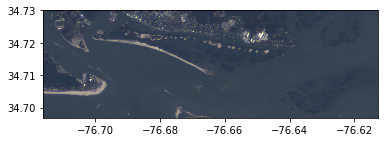

In [52]:
clipped_img = sentinel_img[:, 150:600, 250:1400]
print(clipped_img.shape)
show(clipped_img[[2,1,0], :, :], transform=dataset.transform)

Now we need a rasterio dataset object containing all bands in order to use the mask() function and extract pixel values using geospatial polygons. We'll do that using the merge function:


In [53]:
from rasterio.merge import merge
bands = []
for band in sentinal_band_paths:
    arrs = []
for band_fp in sentinal_band_paths:
    with rasterio.open(band_fp) as band_dataset:
        arrs.append(band_dataset.read(1)[150:600, 250:1400])
        # convert to a numpy array
        sentinel_img = np.array(arrs, dtype=arrs[0].dtype)
        # let's check the shape of this array
        print(sentinel_img.shape)

(1, 450, 1150)
(2, 450, 1150)
(3, 450, 1150)
(4, 450, 1150)
(5, 450, 1150)
(6, 450, 1150)
(7, 450, 1150)
(8, 450, 1150)


In [51]:
bands

[<open DatasetReader name='../../example/sentinel-2/2018-10-13, Sentinel-2B L1C, B01.tiff' mode='r'>,
 <open DatasetReader name='../../example/sentinel-2/2018-10-13, Sentinel-2B L1C, B02.tiff' mode='r'>,
 <open DatasetReader name='../../example/sentinel-2/2018-10-13, Sentinel-2B L1C, B03.tiff' mode='r'>,
 <open DatasetReader name='../../example/sentinel-2/2018-10-13, Sentinel-2B L1C, B04.tiff' mode='r'>,
 <open DatasetReader name='../../example/sentinel-2/2018-10-13, Sentinel-2B L1C, B05.tiff' mode='r'>,
 <open DatasetReader name='../../example/sentinel-2/2018-10-13, Sentinel-2B L1C, B06.tiff' mode='r'>,
 <open DatasetReader name='../../example/sentinel-2/2018-10-13, Sentinel-2B L1C, B07.tiff' mode='r'>,
 <open DatasetReader name='../../example/sentinel-2/2018-10-13, Sentinel-2B L1C, B08.tiff' mode='r'>]

In [60]:
dataset.crs

CRS({'init': 'epsg:4326'})

In [59]:
sentinel_img[0].dtype

dtype('uint8')

In [65]:
! ls ../../products/

sentinel_bands.tif


In [86]:
import os

img_fp = '../../products/'
if not os.path.exists(img_fp):
    os.makedirs(img_fp)

img_fp = img_fp + 'sentinel_bands.tif'

dataset = rasterio.open(sentinal_band_paths[0])

full_sentinal_dataset = rasterio.open(img_fp, 'w', driver='GTiff',
                             height=sentinel_img[0].shape[0], width=sentinel_img[0].shape[1],
                             count=8, dtype=sentinel_img[0].dtype,
                             crs=dataset.crs, transform=dataset.transform)

full_sentinal_dataset.write(sentinel_img)

full_sentinal_dataset.close()

In [89]:
import os

img_dir = '../../products/'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

img_fp = img_dir + 'sentinel_bands.tif'

# Read metadata of first file
with rasterio.open(sentinal_band_paths[0]) as src0:
    meta = src0.meta

# Update meta to reflect the number of layers
meta.update(count = len(sentinal_band_paths))

# Read each layer and write it to stack
with rasterio.open(img_fp, 'w', **meta) as dst:
    for id, layer in enumerate(sentinal_band_paths, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

In [90]:
full_dataset = rasterio.open(img_fp)

In [93]:
clipped_img = full_dataset.read()[:, 150:600, 250:1400]

### Now our goal is to get the pixels from the raster as outlined in each shapefile. 

We'll do this using the rasterio mask function which takes in a dataset and a polygon and then outputs a numpy array with the pixels in the polygon.

Let's run through an example:

In [96]:
full_dataset.crs

CRS({'init': 'epsg:4326'})

In [98]:
shapefile.crs

{'init': 'epsg:32618'}

Whoops looks like the projections don't match! Let's use some geopandas magic to reproject:

In [106]:
shapefile = shapefile.to_crs({'init': 'epsg:4326'}) # shapefile.to_crs(epsg:4326) would also work

In [107]:
# we want to extract the geometry in GeoJSON format

# this generates a list of shapely geometries
geoms = shapefile.geometry.values 
# let's grab a single shapely geometry
geometry = geoms[0] 
print(type(geometry))
print(geometry)

# transform to GeoJSON format
from shapely.geometry import mapping
feature = [mapping(geometry)] # can also do this using polygon.__geo_interface__
print(type(feature))
print(feature)

<class 'shapely.geometry.polygon.Polygon'>
POLYGON ((-76.65445610974965 34.7054574844727, -76.65457138511347 34.70531784849001, -76.6550917986076 34.70555019272821, -76.65485683506891 34.70568982255048, -76.65445610974965 34.7054574844727))
<class 'list'>
[{'type': 'Polygon', 'coordinates': (((-76.65445610974965, 34.705457484472696), (-76.65457138511347, 34.70531784849001), (-76.6550917986076, 34.70555019272821), (-76.65485683506891, 34.705689822550475), (-76.65445610974965, 34.705457484472696)),)}]


In [108]:
# now let's extract the raster values values within the polygon 
out_image, out_transform = mask(full_dataset, feature, crop=True)
        
out_image.shape

(8, 6, 8)

Okay those looks like the right dimensions for our training data. 8 bands and 6x8 pixels seems reasonable given our earlier explorations.

### Building the Training Data for `scikit-learn`

Now let's do it for the whole shapefile and create an array `X` that has all the pixels and an array `y` that has all the training labels.

In [110]:
X = np.array([], dtype=np.int8).reshape(0,8) # pixels for training
y = np.array([], dtype=np.string_) # labels for training

# extract the raster values within the polygon 
with rasterio.open(img_fp) as src:
    for index, geom in enumerate(geoms):
        feature = [mapping(geom)]
        # this is an array of the raster pixels within this feature
        try:
            out_image, out_transform = mask(src, feature, crop=True) 
            # eliminate all the pixels with 0 values for all 4 bands - AKA not actually part of the shapefile
            out_image_trimmed = out_image[:,~np.all(out_image == 0, axis=0)]
            # reshape the array to [pixel count, bands]
            out_image_reshaped = out_image_trimmed.reshape(-1, 8)
            # append the labels to the y array
            y = np.append(y,[shapefile["Classname"][index]] * out_image_reshaped.shape[0]) 
            # stack the pizels onto the pixel array
            X = np.vstack((X,out_image_reshaped))        
        except:
            print('error')

error
error
error
error
error
error
error
error
error
error


#### Pairing Y with X
Now that we have the image we want to classify (our X feature inputs), and the ROI with the land cover labels (our Y labeled data), we need to pair them up in NumPy arrays so we may feed them to Random Forest:

In [112]:
# Find how many training data samples (pixels)?
print('We have {n} samples\n'.format(n=y.shape))

# What are our classification labels?
labels = np.unique(shapefile["Classname"])
print('The training data include {n} classes: {classes}\n'.format(n=labels.size, 
                                                                classes=labels))

# We will need a "X" matrix containing our features, and a "y" array containing our labels
print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

We have (726,) samples

The training data include 7 classes: ['Emergent Wetland' 'Forested Wetland' 'Herbaceous' 'Sand'
 'Scrub-Shrub Wetland' 'Subtidal Haline' 'WetSand']

Our X matrix is sized: (726, 8)
Our y array is sized: (726,)


In [ ]:
X[:, y==]

Text(0.5, 1.0, 'Band Intensities')

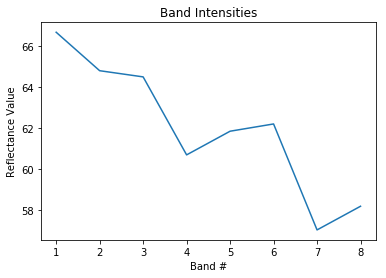

In [156]:
# numbers 1-8
band_count = np.arange(1,9)

band_intensity = np.mean(X[y=='Herbaceous', :], axis=0)

fig, ax = plt.subplots()
# plot them as lines
ax.plot(band_count, band_intensity)

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a title
ax.set_title('Band Intensities')


In [141]:
classes = np.unique(y)
for class_type in classes:
    np.mean(X[y==class_type, :])

34.43181818181818

## Training the Random Forest
Now that we have our X matrix of feature inputs (the spectral bands) and our y array (the labels), we can train our model.

Visit [this web page to find the usage of RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) from `scikit-learn`.

In [113]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=50, oob_score=True)

# Fit our model to training data
rf = rf.fit(X, y)

In [65]:
svm_clf = svm.SVC(gamma='scale', decision_function_shape='ovo')
svm_clf = svm_clf.fit(X, y) 

In [6]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

#### Random Forest diagnostics

With our Random Forest model fit, we can check out the "Out-of-Bag" (OOB) prediction score:

In [114]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 37.74104683195592%


To help us get an idea of which spectral bands were important, we can look at the feature importance scores:

In [116]:
bands = [1, 2, 3, 4, 5, 7, 7, 8]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.1381877365562532
Band 2 importance: 0.12796733370587357
Band 3 importance: 0.11509496214910422
Band 4 importance: 0.11642021465697511
Band 5 importance: 0.12044328289885659
Band 7 importance: 0.11311409375145345
Band 7 importance: 0.1310840232856227
Band 8 importance: 0.13768835299586116


With the largest weights, it looks like the NIR and the Blue bands were the most useful to us.

Let's look at a crosstabulation to see the class confusion. To do so, we will import the [Pandas](http://pandas.pydata.org/) library for some help:

In [117]:
import pandas as pd

# Setup a dataframe -- just like R
df = pd.DataFrame()
df['truth'] = y
df['predict'] = rf.predict(X)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict              Emergent Wetland  Forested Wetland  Herbaceous  Sand  \
truth                                                                       
Emergent Wetland                  166                 0           0     0   
Forested Wetland                    2                85           0     0   
Herbaceous                          0                 0          69     0   
Sand                                1                 1           1    54   
Scrub-Shrub Wetland                 0                 1           1     0   
Subtidal Haline                     0                 0           0     0   
WetSand                             4                 0           0     1   
All                               173                87          71    55   

predict              Scrub-Shrub Wetland  Subtidal Haline  WetSand  All  
truth                                                                    
Emergent Wetland                       0                0        6  172  
Foreste

In [73]:
# Setup a dataframe -- just like R
df = pd.DataFrame()
df['truth'] = y
df['predict'] = neigh.predict(X)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict              Emergent Wetland  Forested Wetland  Herbaceous  Sand  \
truth                                                                       
Emergent Wetland                 1886                13          14    12   
Forested Wetland                  183               128          18    27   
Herbaceous                          5                23         500    53   
Sand                               18                19          85   446   
Scrub-Shrub Wetland               127                24          72    42   
Subtidal Haline                    76                10           0     5   
WetSand                           338                39           9     7   
All                              2633               256         698   592   

predict              Scrub-Shrub Wetland  Subtidal Haline  WetSand   All  
truth                                                                     
Emergent Wetland                      18               14      138  2095  
Fore

Unbelievable, eh? I highly doubt the real confusion matrix will be 100% accuracy. What is likely going on is that we used a large number of trees within a machine learning algorithm to best figure out the pattern in our training data. Given enough information and effort, this algorithm precisely learned what we gave it. Asking to validate a machine learning algorithm on the training data is a useless exercise that will overinflate the accuracy.

Instead, we could have done a crossvalidation approach where we train on a subset the dataset, and then predict and assess the accuracy using the sections we didn't train it on. To get a robust measure of the performance, we would run this using random subsets some number of times.

## Predicting the rest of the image

With our Random Forest classifier fit, we can now proceed by trying to classify the entire image:

We're only going to open a subset of the image because 

In [118]:
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import Window
from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt

In [135]:
with rasterio.open(img_fp) as src:
    # may need to reduce this image size if your kernel crashes, takes a lot of memory
    img = src.read()

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
print(img.shape)
reshaped_img = reshape_as_image(img)
print(reshaped_img.shape)

(8, 450, 1150)
(450, 1150, 8)


In [136]:
# Now predict for each pixel
class_prediction = rf.predict(reshaped_img.reshape(-1, 8))

# Reshape our classification map back into a 2d matrix so we can visualize it
class_prediction = class_prediction.reshape(reshaped_img[:, :, 0].shape)

In [137]:
# because our shapefile came with the labels as strings we want to convert them to a numpy array with ints
class_prediction[class_prediction == 'Subtidal Haline'] = 0
class_prediction[class_prediction == 'WetSand'] = 1
class_prediction[class_prediction == 'Emergent Wetland'] = 2
class_prediction[class_prediction == 'Sand'] = 3
class_prediction[class_prediction == 'Herbaceous'] = 4
class_prediction[class_prediction == 'Scrub-Shrub Wetland'] = 5
class_prediction[class_prediction == 'Forested Wetland'] = 6

class_prediction = class_prediction.astype(int)

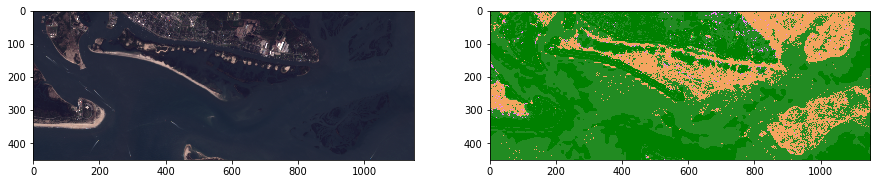

In [138]:
# Visualize

# First setup a 5-4-3 composite
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors
    
# See https://github.com/matplotlib/matplotlib/issues/844/
n = int(np.max(class_prediction))
# Next setup a colormap for our map

colors = dict((
    (0, (0, 0, 139, 255)),      # Blue - Water
    (1, (139,69,19, 255)),      # Blue - WetSand
    (2, (238, 130, 238, 255)),  # Purple - Emergent Wetland
    (3, (244, 164, 96, 255)),   # Tan - Sand
    (4, (50,205,50, 255)),      # Lime - Herbaceous
    (5, (0, 128, 0, 255)),      # Regular Green - Scrub-Shrub
    (6, (34, 139, 34, 255)),    # Forest Green - Forest 
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

# Now show the classmap next to the image
fig, axs = plt.subplots(1,2,figsize=(15,15))

img_stretched = color_stretch(reshaped_img, [3, 2, 1])
axs[0].imshow(img_stretched, vmin=60, vmax=200)

axs[1].imshow(class_prediction, cmap=cmap, interpolation='none')

plt.show()

## Wrapup

We've seen how we can use `scikit-learn` to implement the Random Forest classifier for land cover classification. A couple future directions that immediately follow this tutorial include:

+ Extend the lessons learned in the [visualization chapter](chapter_3_visualization.ipynb) to explore the class separability along various dimensions of the data. For example, plot the SWIR1 band against the NIR band and label each point in the scatter plot a different color according to the training data label.
+ Add additional features - would using NDVI as well as the spectral bands improve our classification?
+ `scikit-learn` includes many machine learning classifiers -- are any of these better than Random Forest for our goal?
+ We've only worked using a single date of imagery -- we could perform a direct classification of change using two dates
+ This approach only leverages the spectral information in Landsat. What would happen if we looked into some spatial information metrics like incorporating moving window statistics? For more on this, see [chapter 7](chapter_6_spatial.ipynb).

We've seen how Random Forest can come up with an estimate of the classification accuracy using the "Out-of-Bag" samples. While this may be a useful metric, we will need to perform a proper accuracy assessment based on a probability sample to conclude anything about the accuracy of the entire area. With the information from the accuracy assessment, we will be able not only to tell how good the map is, but more importantly we will be able to come up with statistically defensible unbiased estimates with confidence intervals of the land cover class areas in the map. For more information, see [Olofsson, *et. al.*, 2013](http://www.sciencedirect.com/science/article/pii/S0034425712004191).